In [1]:
import pandas as pd
import numpy as np
import math

# This has, at the end Euler Discretization Scheme. Note that if n is too big we cannot compute more psi**n..

### Set Free Parameters

Note this is a particular case. We chose epsilon high, and r_max low, because the coefficients are increasing. And after some point, python cannot compute them anymore as they go to inf. That's why r_max is low and epsilon high

In [2]:
alpha = 0.64
lambd = 0.045
mu = -64.938
nu = 44850

# error measures
epsilon = 0.01
theta = 0.9


r_max = 105

### This function returns the list of coefficients

In [3]:
def returns_all_the_first_r_max_coefficients_as_list_2():
    ''' Run this function. This returns the list of coefficients. Up to a_k where 
        k = r_max. '''
    
    coefficients = [np.nan]*(r_max+1)

    a0 = 0 
    a1 = nu/math.gamma(alpha+1)
    coefficients[0] = a0
    coefficients[1] = a1
    
    
    def recursive_convol_coefficients(list_of_coefficients, k):
        ''' return a*_k^2  given the first k-1 a_m coefficients. 
        k is the coefficient a^_k^2 to be returned'''
        if k==1:
            return 0
        else: 
            sum = 0
            for l in range(1,k):
                a_l = list_of_coefficients[l]
                a_k_l = list_of_coefficients[k-l]
                sum += a_l*a_k_l
            return sum
    
    
    def recursive_coefficients(list_of_coefficients, n):
        ''' Given the convoluted coefficient a_k_star_quadro, 
        Given also n, the coefficient a_n to be returned... Note that n = k+1 !!! 
        returns a_k'''
        k = n-1 # n-1 = k
        a_k_star_quadro = recursive_convol_coefficients(list_of_coefficients, k) 
        a_k = list_of_coefficients[k]  
        a_n = (lambd*a_k_star_quadro + mu*a_k)*math.gamma(alpha*k + 1)/math.gamma(alpha*k + alpha + 1)
    
        return a_n

    for i in range(2, r_max+1):
        coefficients[i] = recursive_coefficients( coefficients, i)
        
    return coefficients

In [4]:
coeff = returns_all_the_first_r_max_coefficients_as_list_2()
#coeff

In [5]:
### Poi posso stampare in un dataframe e metterlo nella tesi i risultati/ coefficienti

In [6]:
len(coeff)

106

### Estimating the radius of convergence

In [ ]:
### DO NOT RUN THIS. IT IS A PLOT FOR THE THESIS

ott = pd.DataFrame({ "k": [i for i in range(0,106)], "a_k": coeff}).set_index('k')

ott['c'] = np.log(np.abs(ott['a_k']))

plot = ott['c'].plot( ylabel= "log(|a_k|)", title= "f(k) = log(|a_k|)")

fig = plot.get_figure()
fig.set_size_inches(10, 6)
fig.savefig("output.png", dpi=200)

In [7]:
a_r_max = coeff[-1]
a_primo_r_max = a_r_max*math.gamma(alpha*r_max+1)/(math.gamma(alpha*r_max-alpha+1)*(alpha*r_max+1-alpha))

R_estimate = abs(a_primo_r_max)**(-1/(alpha*r_max))
R_estimate

0.0010881915196240175

In [8]:
T = 1/252  ## We will need to use the hybrid, since t= 1/252 è più grande di R_estimate!!
T

0.003968253968253968

### Computing where should we truncate

In [9]:
r_0 = math.log(epsilon*(1-theta))/alpha/math.log(theta)-1
r_0 = int(np.round(r_0)+1)
r_0            ### Hey but this r_0 is independent by n. In fact,
               # We should be fix first n, then compute theta_n(n) (defined below),
               # Only then we can compute r_0, and therefore the truncated coefficients!!!

102

In [10]:
slicing = slice(0,r_0)

coeff_truncated = coeff[slicing]

## Euler Scheme

In [11]:
### We use the theta function defined in 4.6
## IN Truth we set it always fixed to 0.9. Because, anyways, we do not care much for low values of n


In [12]:
# We won't be using this in the first exercise, but maybe in the next exercises we will need it

def theta_n(n):
    ''' Theta in function of n '''
    if n<16:
        return 0.5
    if n<32:
        return 0.65
    if n>4096:
        return 0.925
    else:
        return min(0.65+ 0.3*((n-32)/4064)**0.25  ,0.925)

For convenience we will compute r_0 with a theta fixed (theta = 0.9). Why this?
 Because the value of r_0 changes basing on theta. And, as we observed, if r_0 is too big,
It might be that we don't have enough coefficients. Since in this case the coefficients go to infinity,
 We want to be sure we stay below the threshold. So we use a theta fixed, even for different n's values!

In [13]:
def poly(lst, x):   
    ''' Evaluate the polynomial with coefficients lst= [a0,a1,a2,...] in x
    Pol: a0 + a1*x**alpha + a2*x**(2*alpha) + .... '''
    n, tmp = 0, 0
    for a in lst:
        tmp = tmp + (a * (x**(n*alpha)))
        n += 1

    return tmp

poly([1,2,3], 2)  # 1 + 2*2 + 3*4 

11.401827625012281

In [14]:
def computing_psi_n(n):
    ''' Just Give n. This function makes use of the parameters. Then also of the list "coeff_truncated" 
    '''
    
    disc_times = [k*T/n for k in range(0,n+1)]
    
    theta = 0.9
    #theta = theta_n(n) # Only In This Example, Because The Theta fixed at the beginning would go out otherwise!
    
    
    
    k_0 = math.floor(R_estimate*theta*n/T)  ### Up to t_k_0 we will use truncated series. Then Euler Schema
    
    t_k_0 = disc_times[k_0]
    
    
    values_assumed_in_disc_times = [np.nan]*(n+1)
    
    
    ### Here We Evaluate The Truncated Series!
    for k in range(0,k_0+1):
        values_assumed_in_disc_times[k] = poly(coeff_truncated, disc_times[k])
    
    
    ### Here Instead We Use The Euler Scheme
    def compute_c_i(alpha, l):
        if l == 0:
            return 1
        else: 
            return (l+1)**alpha - l**alpha
    
    
    
    for k in range(k_0+1, n+1):
        factor_1 = 1/math.gamma(alpha + 1)*(T/n)**alpha
        addend_2 = nu*k**alpha 
        addend_3 = 0
        for l in range(1,k):
            psi_n_t_l = values_assumed_in_disc_times[l]
            addend_3 += compute_c_i(alpha, k-l-1)*psi_n_t_l*(lambd*psi_n_t_l + mu)
        
        factor_2 = addend_2 + addend_3
        
        result = factor_1*factor_2
        
        values_assumed_in_disc_times[k] = result
            
    
    print("t_k0=", t_k_0)
    
    #return disc_times, values_assumed_in_disc_times
    return pd.DataFrame({"time": disc_times, "value": values_assumed_in_disc_times}), t_k_0
    

# Plots Do not run the followings. These are for the thesis

In [ ]:
plot = computing_psi_n(32)[0].set_index('time').plot( marker="x", linewidth=0)
tk0 = computing_psi_n(32)[1]

plot.axvline(x = tk0, linewidth=1, color='r')
plot.text(tk0,600,"t_k0",rotation=0, fontsize= 20, color="r")


fig = plot.get_figure()
fig.set_size_inches(13, 8)

In [ ]:
def plot_psi_n(n, nameToSave):
    df, tk0 = computing_psi_n(n)
    
    plot = df.set_index('time').plot( marker="x", linewidth=0, title = nameToSave[:-4])

    plot.axvline(x = tk0, linewidth=1, color='r')
    plot.text(tk0,600,"t_k0",rotation=0, fontsize= 20, color="r")


    fig = plot.get_figure()
    fig.set_size_inches(13, 8)
    fig.savefig(nameToSave, dpi=200)

In [ ]:
plot_psi_n(1024, "n = 1024.png")

# Experiment nr. 2 Computing c_1(n)  

In [15]:
def c_1(n):
    return 2*n*(computing_psi_n(n)[0].iloc[-1].value - computing_psi_n(2*n)[0].iloc[-1].value)

In [16]:
c_1(2048)

t_k0= 0.0009785001240079365
t_k0= 0.0009785001240079365


198.67725828383118

computing c1 for various n and seeing the time that it takes.

In [ ]:
# DONT RUN THIS!!

import time
start_time = time.time()

c_1(4096*2)

print("--- %s seconds ---" % (time.time() - start_time))



df_ci_times = {}
df_ci_values = {}

#for i in [4,8,16,32,64,128,256,512,1024,2048,4096, 4096*2, 4096*4]:
    
#    start_time = time.time()
 #   df_ci_values[i] = c_1(i)
  #  df_ci_times[i] = time.time() - start_time

final = pd.DataFrame({"n": [key for key in df_ci_times], "c_n": [df_ci_values[key] for key in df_ci_values], "comput_time -sec-": [df_ci_times[key] for key in df_ci_times]})

final = final.set_index("n")
final

final['comput_time_rapport'] = final['comput_time -sec-']/final['comput_time -sec-'].shift(1)

final

#final.to_csv('up_to_4096times8.csv')

In [20]:
final = pd.read_csv('up_to_4096times8.csv')
final.set_index('n')
final

,n,c_n,comput_time -sec-,comput_time_rapport
0,4,244.789055,0.005540,NaN
1,8,247.620217,0.005834,1.053153
2,16,236.228489,0.004871,0.834941
3,32,224.837873,0.005614,1.152562
4,64,215.948954,0.009873,1.758578
5,128,209.595284,0.018452,1.868924
6,256,205.598250,0.059347,3.216283
7,512,202.148404,0.221983,3.740396
8,1024,199.883079,0.862326,3.884654
9,2048,198.677258,3.469351,4.023247


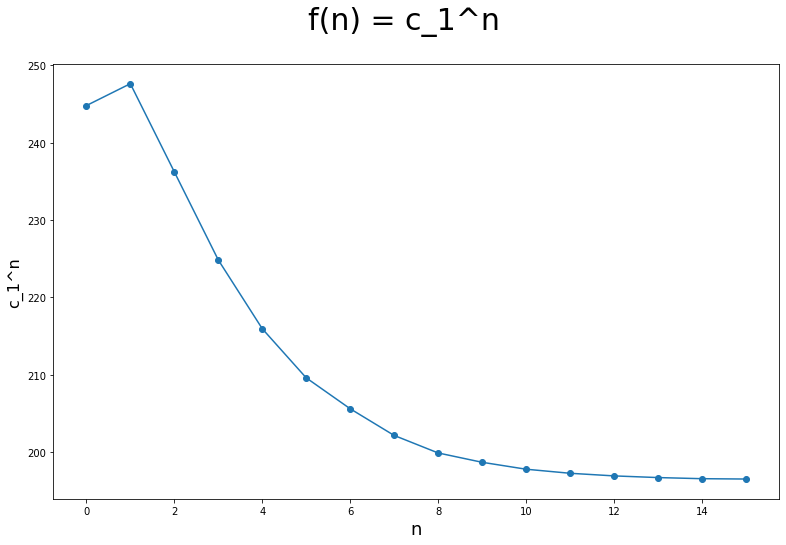

In [21]:
plot = final['c_n'].plot( marker="o")
fig = plot.get_figure()

fig.set_size_inches(13, 8)
fig.suptitle('f(n) = c_1^n', fontsize=30)    # SET BIG TITLE
plot.set_xlabel('n', fontsize=18)
plot.set_ylabel('c_1^n', fontsize=16)
fig.savefig('c_1^n', dpi=200)


In [22]:
final = final.reset_index()
final['log(n) '] = np.log(final['n'])

cref = 196.510382

final['cn-cref'] = final['c_n'] - cref

final['log(cn-cref) '] = np.log(final['cn-cref'])

final_log = final.iloc[:-1].set_index('log(n) ')

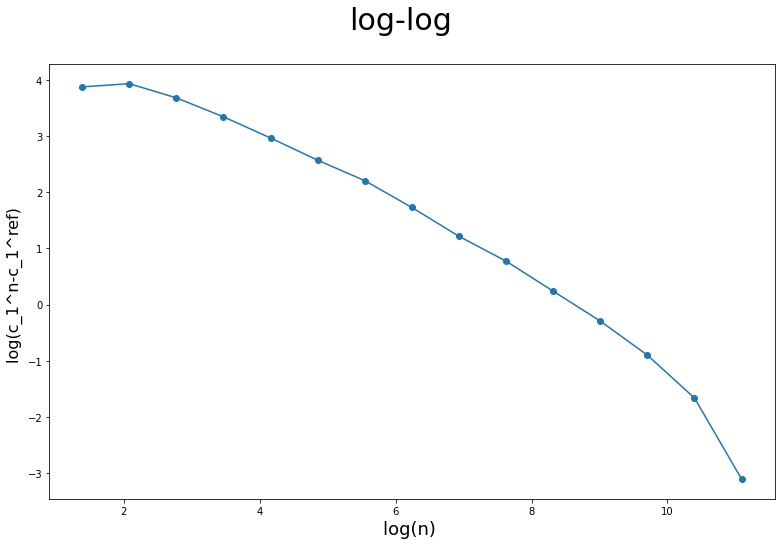

In [27]:
plot = final_log['log(cn-cref) '].plot(marker="o")

fig = plot.get_figure()

fig.set_size_inches(13, 8)
fig.suptitle('log-log', fontsize=30)    # SET BIG TITLE
plot.set_xlabel('log(n) ', fontsize=18)
plot.set_ylabel('log(c_1^n-c_1^ref) ', fontsize=16)
fig.savefig('c_1log', dpi=200)

## Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

x = final_log.index.values
y = final_log['log(cn-cref) ']

x = x.reshape(-1,1)

reg = LinearRegression().fit(x, y.values)

In [29]:
reg.coef_

array([-0.68382593])

In [30]:
beta = 1 -0.68382593
beta

0.31617407

# Computational Times

In [41]:
comput_times = final.set_index('n')['comput_time -sec-']

In [44]:
comput_times = comput_times.reset_index()

In [47]:
comput_times['logn'] = np.log(comput_times['n'])
comput_times['logcomp'] = np.log(comput_times['comput_time -sec-'])

In [52]:
comput_times = comput_times.set_index('logn')['logcomp']

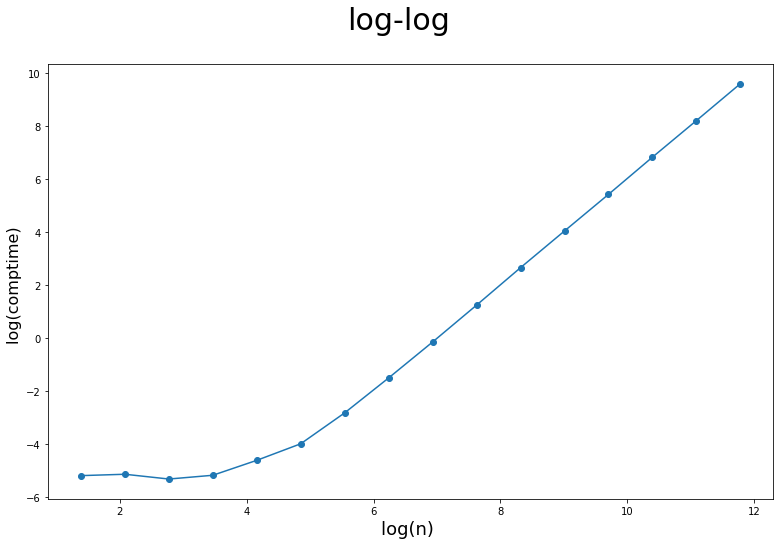

In [67]:
plot = comput_times.plot(marker= "o")

fig = plot.get_figure()

fig.set_size_inches(13, 8)
fig.suptitle('log-log', fontsize=30)    # SET BIG TITLE
plot.set_xlabel('log(n) ', fontsize=18)
plot.set_ylabel('log(comptime) ', fontsize=16)
fig.savefig('comp_times', dpi=200)

In [54]:
comput_times.values

array([-5.19582293, -5.14403482, -5.32442934, -5.1824418 , -4.61793615,
       -3.99257344, -2.82434712, -1.50515575, -0.14812172,  1.24396763,
        2.65895467,  4.04491949,  5.42604268,  6.83147195,  8.21275996,
        9.60631528])

In [64]:


x = comput_times.index.values[6:]
y = comput_times.values[6:]

x = x.reshape(-1,1)

reg = LinearRegression().fit(x, y)

In [65]:
reg.coef_

array([1.99993845])